Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


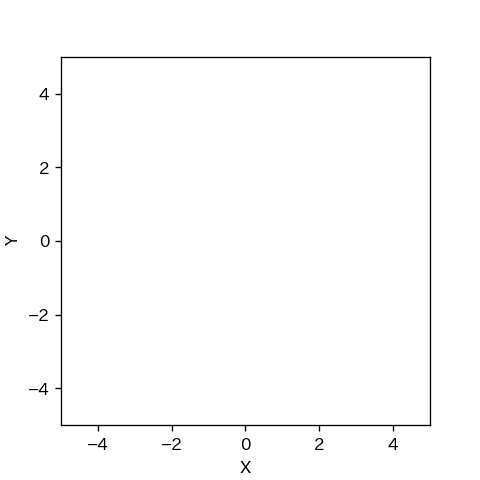

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


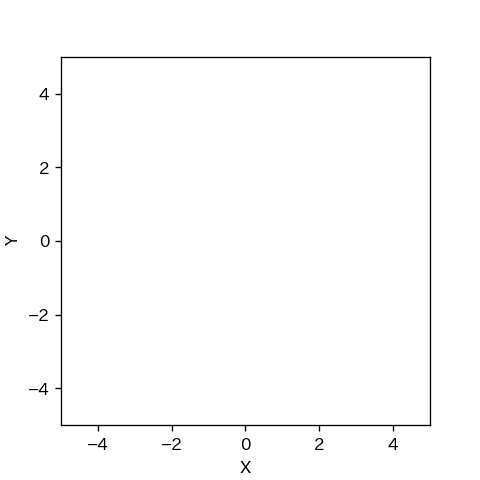

(array([-1.20253361,  2.24784809, -2.76961589]),
 array([4.1850594 , 4.9686591 , 3.06112427]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[3.99321907258125]
[4.281199328519261]
[3.8030039726109788, 1.6036306791212158]
0 真値: [2.03329712 3.04390111 2.03686677] 推定値: [2.44023277 3.53505153 1.52745545] 誤差: 0.6378286280341255
1
[5.596498991998745]
1 真値: [3.50996444 2.84707124 7.56561984] 推定値: [3.32705404 2.4846821  0.50494703] 誤差: 0.40593361958169144
2
[4.33908973134541]
[4.141513887549466, 4.229731483905903]
2 真値: [2.61963063 1.5310213  7.91051258] 推定値: [3.11367851 1.63928462 8.22092437] 誤差: 0.5057709513466963
3
[6.0495057826599465]
3 真値: [-2.86444562  0.41336815  3.2818202 ] 推定値: [-2.46693835  0.67279479  3.44582312] 誤差: 0.47467274692153216
4
[1.7902865206802556]
4 真値: [2.17874262 4.96965206 3.29578792] 推定値: [1.42986523 1.6576861  5.1440892 ] 誤差: 3.3955759288697993
[6.166952550254468]
[4.049203896808821]
5 真値: [-4.25189446  3.73939662  5.74273328] 推定値: [-2.33742706  2.90118057 -1.7545819 ] 誤差: 2.089926212620504
[1.2972759513817156]
6 真値: [2.88120537 2.44185282 5.66012799] 推定値: [ 2.98236696  2.75426596 -0.60824351] 誤差: 0.3283

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[6.396325382458997]
20 真値: [-3.9282051  -2.79557453  2.96335315] 推定値: [-2.77722372 -5.59567351  2.8315011 ] 誤差: 3.0274267096339806
[1.7974843553023414]
21 真値: [ 1.88614434 -3.3311797   6.08008291] 推定値: [ 2.31463804 -2.6929124   2.02292364] 誤差: 0.7687600308948258
13
[6.375604480458764]
22 真値: [ 1.64442924 -2.95259852  5.25468547] 推定値: [ 1.57031401 -3.23472865  6.14162731] 誤差: 0.29170272356106497
14
[4.420747353190486]
23 真値: [-2.28634488 -1.38037516  4.8382717 ] 推定値: [-1.95908878 -1.11563247  4.5739499 ] 誤差: 0.42093377900391454
15
[3.912146765042036, 3.23923224320911]
24 真値: [0.18314359 1.19095234 5.66965323] 推定値: [0.38844653 0.80900507 5.64858415] 誤差: 0.4336277373230095
16
[5.971174633076894, 7.105839734836345]
25 真値: [ 0.37102248 -2.70355651  7.43050985] 推定値: [ 0.26470428 -2.61779969  7.45608353] 誤差: 0.1365935328314787
17
[4.8751316150524024]
[3.651120508866756, 6.813267028136515]
26 真値: [-2.21523136  0.56308107  4.22796999] 推定値: [-2.27517652  0.87027528  4.0992143 ] 誤差: 0.31298835005